In [105]:
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import math
import pandas as pd

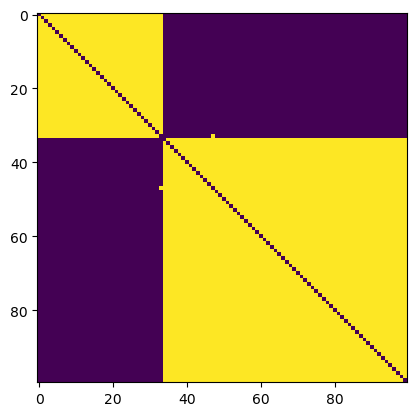

In [986]:
n = 100
dt = 0.001
T = 1

# default, connected
# A = np.ones((n,n))
# A = np.triu(A, 1)
# A = A + A.T

# Erdos Renyi
# p = .2
# A = np.random.rand(n,n) # random matrix
# A = np.where(A < p, 1, 0) # adjacency matrix
# A = np.triu(A, 1) # triangular matrix
# A = A + A.T # symmetric matrix

# Small World
# A = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         if i == j:
#             continue
#         if np.abs(i-j) < 5:
#             A[i,j] = 1
#         elif np.abs(i-j) > n-5:
#             A[i,j] = 1
#         else:
#             A[i,j] = 0

# plot

#Simulating for the Barbell Population Model with a Stopping Criterion
pop = np.random.randint(25,75) #minimum and maximum population sizes
A = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if i == j:
            A[i,j] = 0
        elif (i <= pop and j <= pop) or (i > pop and j > pop):
            A[i,j] = 1
        else:
            A[i,j] = 0
sender = np.random.randint(0,pop+1)
receiver = np.random.randint(pop+1,99)
A[sender,receiver] = 1
A[receiver,sender] = 1

plt.imshow(A)
plt.show()

## Second Approach to Accumulation of Private Information

$\frac{dy_j}{dt} = \pm \mu dt + \sqrt{2\mu}dW_j(t) + \frac{dL(t)}{dt}$, where $L(t) = \ln(\frac{P(H_+)}{P(H_-)})$ at time t, where the $P(H_+)$ and $P(H_-)$ are given by a logistic classification model built on previous rounds of training samples.

In [987]:
# Creating a set of uniformly distributed thresholds that lie between a minimum and maximum threshold, dealer's choice for how wide this interval is
thresh = np.array([np.random.uniform(0.10,0.8) for i in range(n)])
T = 1
per = 10

# initial conditions
y = np.zeros((n, int(T/dt)))

# Simulating a run of the agents
def sim(y0,Adj,thetas,mu,period,N,Time,delta_t,FeatFunc,stop,tstop = False,model = False):
    kicks = np.zeros(N) #Easy way to tell when some agent has kicked
    neighbors = np.zeros(N) #This is going to be a weighted average of the thresholds of the neighbors that have decided
    train = [] #Training data for the model
    # simulation
    firstkick = N*[0]
    LLR = np.zeros(N)
    pkicks = np.zeros(N)
    for t in range(1,int(Time/delta_t)):
        
        if t >= 2:
            pkicks = np.array([y0[ind,t-2]/abs(y0[ind,t-2]) if abs(y0[ind,t-2]) >= thetas[ind] else 0 for ind in range(N)])
            
        sk = sum(abs(kicks))
        features = FeatFunc(y0,Adj,firstkick,kicks,pkicks,thetas,N)
        
        # update state
        LLPrev = LLR
        if model: #If we actually have a model to use to form a Log-Likelihood ratio, then you need to predict the correct decision
            for m in range(N):
                res = model.predict_proba(np.array(features))[0]
                LLR[m] = np.log(res[1]/res[0])

        # Update Kicks and The State
        cnt = 0

        for yj in range(N):
            if abs(y0[yj,t-1]) < thetas[yj]: 
                y0[yj,t] = y0[yj,t-1] + delta_t*mu + np.sqrt(2*abs(mu)*delta_t)*np.random.normal(0.0,1)+(LLR[yj]-LLPrev[yj])
        
                if y0[yj,t] <= -1*thetas[yj]: #If the new predicted information for an agent is outside of their threshold
                    #Then they make a decision, and they're registered as having "kicked"
                    y0[yj,t] = -1
                    kicks[yj] = -1
                    cnt += 1 #Adding the total number of people who have decided in favor of H-
                if y0[yj,t] >= thetas[yj]:
                    y0[yj,t] = 1
                    kicks[yj] = 1
                    cnt += 1 #Adding the total number of people who have decided in favor of H+
                #else:
                 #   kicks[yj] = 0
            else:
                y0[yj,t] = y0[yj,t-1]
                cnt += 1
                
        while sk != sum(abs(kicks)):
            
            sk = sum(abs(kicks))
            
            features = FeatFunc(y0,Adj,firstkick,kicks,pkicks,thetas,N)
            
            LLPrev = LLR
            if model: #If we actually have a model to use to form a Log-Likelihood ratio, then you need to predict the correct decision
                for m in range(N):
                    res = model.predict_proba(np.array(features))[0]
                    LLR[m] = np.log(res[1]/res[0])

            for yj in range(N):
                
                if abs(y0[yj,t]) < thetas[yj]: 
                    y0[yj,t] = y0[yj,t] + (LLR[yj]-LLPrev[yj])
                
                    if y0[yj,t] <= -1*thetas[yj]: #If the new predicted information for an agent is outside of their threshold
                        #Then they make a decision, and they're registered as having "kicked"
                        y0[yj,t] = -1
                        kicks[yj] = -1
                        cnt += 1 #Adding the total number of people who have decided in favor of H-
                    if y0[yj,t] >= thetas[yj]:
                        y0[yj,t] = 1
                        kicks[yj] = 1
                        cnt += 1 #Adding the total number of people who have decided in favor of H+
                    #else:
                     #   kicks[yj] = 0
                
            if sum(abs(kicks)) >= stop: #If a certain threshold of people have decided, then end the sim
                break
                
            if tstop: #If there's a time threshold
                if t >= tstop: #If a certain threshold of time has passed, end the sim
                    break
                    
        features = FeatFunc(y0,Adj,firstkick,kicks,pkicks,thetas,N)

        if t%period == 0: #Set a period along which you want training samples to be collected
            train += features
                
        if sum(abs(kicks)) >= stop: #If a certain threshold of people have decided, then end the sim
                break
        if tstop: #If there's a time threshold
            if t >= tstop: #If a certain threshold of time has passed, end the sim
                break

    return train,y0,t #This returns  a training dataset, the simulated behavior, and the time the sim ended

In [988]:
def ModelFeatures1(yvals,Adj,fk,k,pk,th,num):
    stuff = []
    for j in range(num):
        B = [] 
        #This function here is going through and finding whether a decision has been made by a neighbor
        #Using the adjacency matrix, and then summing up the thresholds multiplied by the decision that was made (1,-1,0)
        #Then, to form the average, this weighted sum is divided by the total number of neighbors nearby
        B = []
        diff = k-pk
        count = 0
        for i in range(num):
            if diff[i] < 0:
                B += [-1 if Adj[i,j]*diff[i] < -1 else Adj[i,j]*diff[i]]
                count += 1
            elif diff[i] > 0:
                B += [1 if Adj[i,j]*diff[i] > 1 else Adj[i,j]*diff[i]]
                count += 1
            else:
                B += [0]
        if fk[j] != 0:
            fkick = [th[l]*yvals[l,fk[j]] if abs(yvals[l,fk[j]]) >= 1 else 0 for l in range(num)]
        else:
            fkick = np.zeros(num)
            
        stuff += [[B@th/count if count != 0 else 0,Adj[:,j]@diff,fk[j],Adj[:,j]@fkick]]
    return stuff

def ModelFeatures2(yvals,Adj,fk,k,pk,th,num):
    stuff = []
    for j in range(num):
        B = [] 
        #This function here is going through and finding whether a decision has been made by a neighbor
        #Using the adjacency matrix, and then summing up the thresholds multiplied by the decision that was made (1,-1,0)
        #Then, to form the average, this weighted sum is divided by the total number of neighbors nearby
        B = []
        C = []
        diff = k-pk
        count = 0
        ctot = 0
        for i in range(num):
            if diff[i] < 0:
                B += [-1 if Adj[i,j] > 0 else 0]
                count += 1
            elif diff[i] > 0:
                B += [1 if Adj[i,j] > 0 else 0]
                count += 1
            else:
                B += [0]
        for i2 in range(num):
            if k[i2] < 0:
                C += [-1 if Adj[i2,j] > 0 else 0]
                ctot += 1
            elif k[i2] > 0:
                C += [1 if Adj[i2,j] > 0 else 0]
                ctot += 1
            else:
                C += [0]
                
        if fk[j] != 0:
            fkick = [th[l]*yvals[l,fk[j]] if abs(yvals[l,fk[j]]) >= 1 else 0 for l in range(num)]
        else:
            fkick = np.zeros(num)
            
        tn = sum(Adj[:,j])
        stuff += [[B@th/count if count != 0 else 0,Adj[:,j]@diff,C@th/tn,abs(k)@Adj[:,j]]]
    return stuff

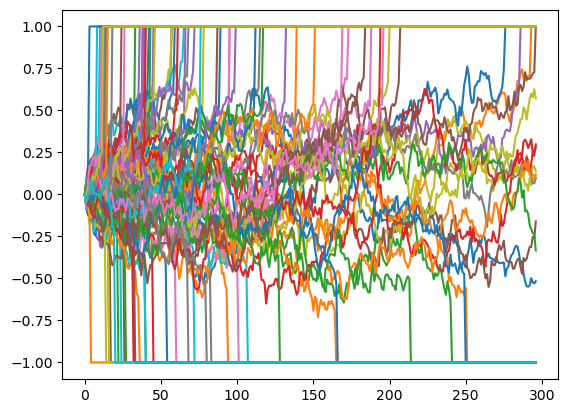

In [989]:
training,ysim,tstop = sim(y,A,thresh,1,per,n,1,dt,ModelFeatures2,90,tstop=False,model = False)
for i in range(n):
    plt.plot(ysim[i,:tstop+1])
plt.show()

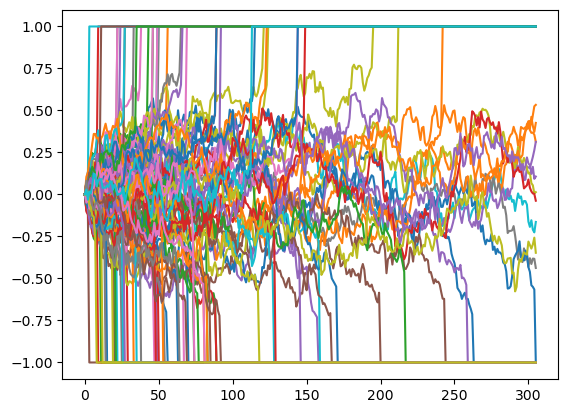

In [990]:
training2,ysim2,tstop2 = sim(y,A,thresh,-1,per,n,1,dt,ModelFeatures2,90,tstop=False,model = False)
for i in range(n):
    plt.plot(ysim2[i,:tstop2+1])
plt.show()

In [991]:
def RR(yvec,correct,tstop): #Calculating the reward rate of the given population (accuracy/total time to decide)
    cor = 0
    inc = 0
    und = 0
    for i in yvec:
        if i == correct:
            cor += 1
        elif i == -1*correct:
            inc += 1
        else:
            und += 1
    return (cor/(inc+und+cor))/tstop

RR(ysim2[:,tstop2],-1,tstop2)

0.0018032786885245904

In [992]:
RR(ysim[:,tstop],1,tstop)

0.0011824324324324323

In [993]:
def TrainData(labels,data,truevals):
    df = []
    for index in range(len(data)):
        df += [data[index]+[truevals[index]]]
    
    df = pd.DataFrame(df, columns = labels, dtype = float)
    
    return df

df = TrainData(['Aggregate','NewDecision','AggregateTot','TotDec','True'],training+training2,len(training)*[1]+len(training2)*[-1])

def SocialLC(data,xlabs,ylab):

    X = np.array(data[xlabs])
    ydat = data[ylab]
    model = LogisticRegression()
    model.fit(X, ydat)
    
    return model

logreg = SocialLC(df,['Aggregate','NewDecision','AggregateTot','TotDec'],'True')

In [754]:
sum(np.zeros(100))

0.0

In [755]:
LLR = []
for i in res:
    LLR += [np.log(i[0]/i[1])]
LLR

[-2.347757155002384,
 -2.9749068503620593,
 1.2541542856672694,
 2.3958627582654652]

In [487]:
#logreg.predict(np.array([0.25,0.30,-0.1,-0.2]).reshape(-1,1))

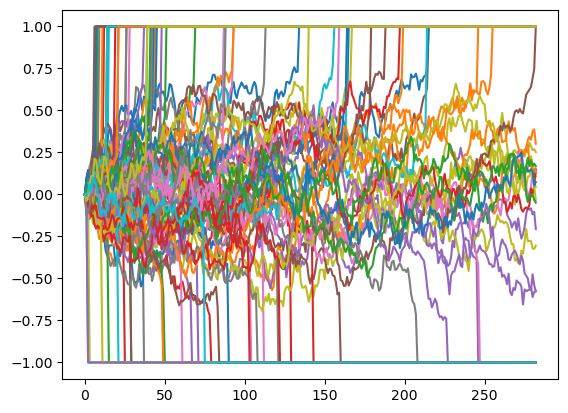

In [994]:
training3,ysim3,tstop3 = sim(y,A,thresh,1,per,n,1,dt,ModelFeatures2,85,tstop=False,model = logreg)
for i in range(n):
    plt.plot(ysim3[i,:tstop3+1])
plt.show()

In [995]:
RR(ysim3[:,tstop3],1,tstop3)

0.001843971631205674

In [997]:
ytrain = len(training)*[1]+len(training2)*[-1]+len(training3)*[1]
label = ['Aggregate','NewDecision','AggregateTot','TotDec','True']
df = TrainData(label,training+training2+training3,ytrain)

logreg = SocialLC(df,['Aggregate','NewDecision','AggregateTot','TotDec'],'True')

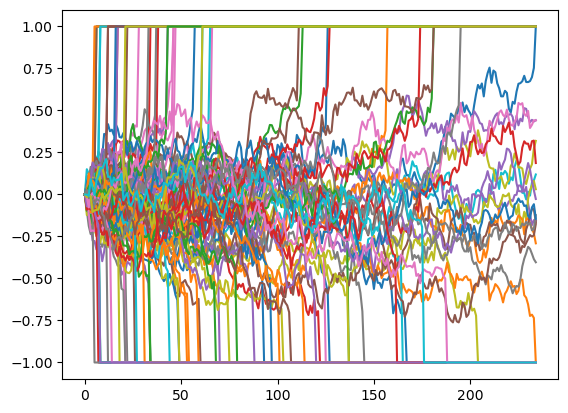

In [998]:
training4,ysim4,tstop4 = sim(np.zeros((100, int(1/0.001))),A,thresh,-1,10,100,1,0.001,ModelFeatures2,85,tstop = False,model = logreg)
for i in range(n):
    plt.plot(ysim4[i,:tstop4+1])
plt.show()

In [999]:
ytrain = len(training)*[1]+len(training2)*[-1]+len(training3)*[1]+len(training4)*[-1]
label = ['Aggregate','NewDecision','AggregateTot','TotDec','True']
df = TrainData(label,training+training2+training3+training4,ytrain)

logreg = SocialLC(df,['Aggregate','NewDecision','AggregateTot','TotDec'],'True')

In [1000]:
rewards = []
accuracy = []
for i in np.arange(10,201,1):
    true = np.random.choice([-1,1])
    training5,ysim5,tstop5 = sim(np.zeros((100, int(1/0.001))),A,thresh,true,10,100,1,0.001,ModelFeatures2,100,i,model = logreg)
    accuracy += [list(ysim5[:,tstop5]).count(true)/len(ysim5)]
    rewards += [RR(ysim5[:,tstop5],true,tstop5)]
    print(f'Stopping Time {i}')

Stopping Time 10
Stopping Time 15
Stopping Time 20
Stopping Time 25
Stopping Time 30
Stopping Time 35
Stopping Time 40
Stopping Time 45
Stopping Time 50
Stopping Time 55
Stopping Time 60
Stopping Time 65
Stopping Time 70
Stopping Time 75
Stopping Time 80
Stopping Time 85
Stopping Time 90
Stopping Time 95
Stopping Time 100
Stopping Time 105
Stopping Time 110
Stopping Time 115
Stopping Time 120
Stopping Time 125
Stopping Time 130
Stopping Time 135
Stopping Time 140
Stopping Time 145
Stopping Time 150
Stopping Time 155
Stopping Time 160
Stopping Time 165
Stopping Time 170
Stopping Time 175
Stopping Time 180
Stopping Time 185
Stopping Time 190
Stopping Time 195
Stopping Time 200


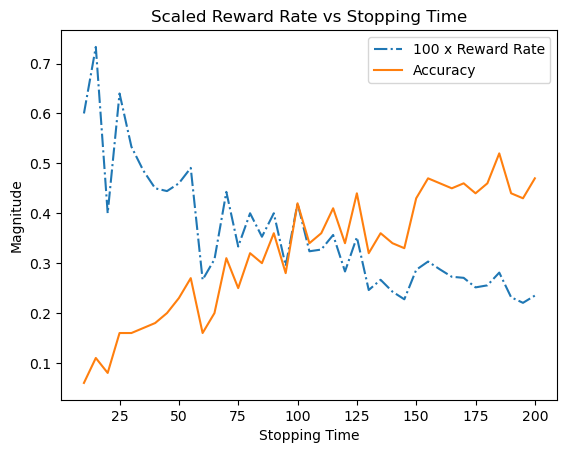

In [1001]:
plt.plot(np.arange(10,201,1),[100*i for i in rewards],'-.',label = '100 x Reward Rate')
#for j in range(len(accuracy)):
  #  plt.text(np.arange(10,205,5)[j]-5,accuracy[j],s = f'{accuracy[j]}',fontsize = 10,alpha = 0.7)
plt.plot(np.arange(10,201,1),accuracy,label = 'Accuracy')
plt.xlabel('Stopping Time')
plt.ylabel('Magnitude')
plt.title('Scaled Reward Rate vs Stopping Time')
plt.legend()
plt.show()

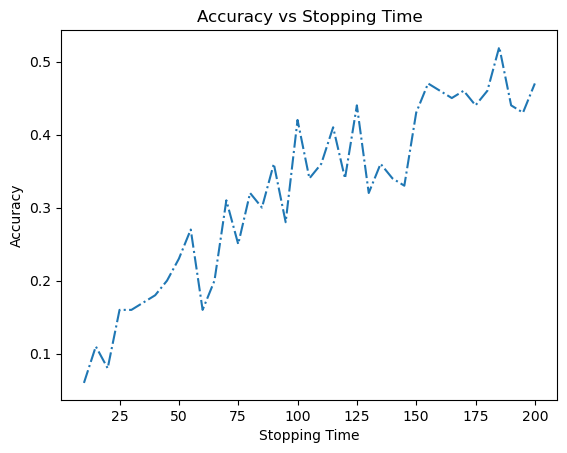

In [1002]:
plt.plot(np.arange(10,201,1),accuracy,'-.')
plt.xlabel('Stopping Time')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Stopping Time')
plt.show()

In [1010]:
rewards = []
accuracy = []
for i in np.arange(0,1.01,0.01):
    true = np.random.choice([-1,1])
    thresh = np.array([np.random.uniform(i,0.9) for j in range(n)])
    training5,ysim5,tstop5 = sim(np.zeros((100, int(1/0.001))),A,thresh,true,10,100,1,0.001,ModelFeatures2,90,1000,model = logreg)
    accuracy += [list(ysim5[:,tstop5]).count(true)/len(ysim5)]
    rewards += [RR(ysim5[:,tstop5],true,tstop5)]
    print(f'Minimum Theta {i}')

Minimum Theta 0.0
Minimum Theta 0.01
Minimum Theta 0.02
Minimum Theta 0.03
Minimum Theta 0.04
Minimum Theta 0.05
Minimum Theta 0.06
Minimum Theta 0.07
Minimum Theta 0.08
Minimum Theta 0.09
Minimum Theta 0.1
Minimum Theta 0.11
Minimum Theta 0.12
Minimum Theta 0.13
Minimum Theta 0.14
Minimum Theta 0.15
Minimum Theta 0.16
Minimum Theta 0.17
Minimum Theta 0.18
Minimum Theta 0.19
Minimum Theta 0.2
Minimum Theta 0.21
Minimum Theta 0.22
Minimum Theta 0.23
Minimum Theta 0.24
Minimum Theta 0.25
Minimum Theta 0.26
Minimum Theta 0.27
Minimum Theta 0.28
Minimum Theta 0.29
Minimum Theta 0.3
Minimum Theta 0.31
Minimum Theta 0.32
Minimum Theta 0.33
Minimum Theta 0.34
Minimum Theta 0.35000000000000003
Minimum Theta 0.36
Minimum Theta 0.37
Minimum Theta 0.38
Minimum Theta 0.39
Minimum Theta 0.4
Minimum Theta 0.41000000000000003
Minimum Theta 0.42
Minimum Theta 0.43
Minimum Theta 0.44
Minimum Theta 0.45
Minimum Theta 0.46
Minimum Theta 0.47000000000000003
Minimum Theta 0.48
Minimum Theta 0.49
Minimum Th

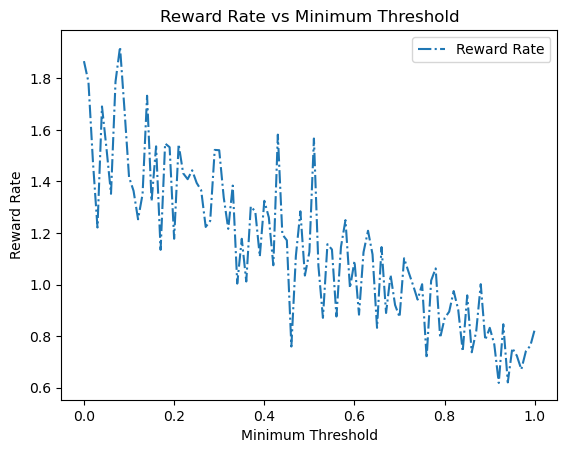

In [1018]:
plt.plot(np.arange(0,1.01,0.01),[1000*i for i in rewards],'-.',label = 'Reward Rate')
#for j in range(len(accuracy)):
  #  plt.text(np.arange(10,205,5)[j]-5,accuracy[j],s = f'{accuracy[j]}',fontsize = 10,alpha = 0.7)
#plt.plot(np.arange(0,1.01,0.01),accuracy,label = 'Accuracy',col = 'orange')
plt.xlabel('Minimum Threshold')
plt.ylabel('Reward Rate')
plt.title('Reward Rate vs Minimum Threshold')
plt.legend()
plt.show()

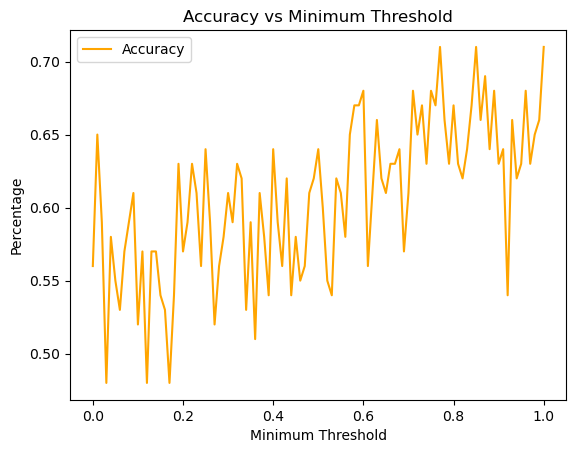

In [1020]:
plt.plot(np.arange(0,1.01,0.01),accuracy,label = 'Accuracy',color = 'orange')
plt.xlabel('Minimum Threshold')
plt.ylabel('Percentage')
plt.title('Accuracy vs Minimum Threshold')
plt.legend()
plt.show()